In [1]:
import sys

ssh = True
if ssh:
    data_folder = "/home/gperri-ext/master_thesis/data//"
    sys.path.append('/home/gperri-ext/master_thesis/')
else:
    data_folder = r"C:\Users\Giova\thesis\master_thesis\data//"
    sys.path.append(r"C:\Users\Giova\thesis\master_thesis//")


# Sys.path is a list of directories where the Python interpreter searches for modules. 

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras, config
from keras import layers
from keras.callbacks import EarlyStopping

physical_devices = config.list_physical_devices('GPU')
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras

from modules.windowing_data import multivariate_data, prepare_dataset_for_training
from modules.visualization import plot_model_loss, plot_error_metrics, plot_error_metrics_barchart
from modules.evaluation_func import timeseries_evaluation_metrics_func, single_timeseries_evaluation_metrics_func, NMAE_error, calculate_evaluation_metrics, evaluate_and_plot_timeseries
from modules.temp_features import make_yearly_dataset
from modules.daily_errors import calculate_mae_errors, calculate_mape_errors, calculate_rmse_errors, visualize_errors_with_timestamps, filter_errors_at_midnight

2024-04-22 08:57:01.688019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_2999773/193339093.py:37: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
import importlib
importlib.reload(sys.modules['modules.windowing_data'])

<module 'modules.windowing_data' from '/home/gperri-ext/master_thesis/modules/windowing_data.py'>

#### Importing data

In [3]:
file_name = "df_Italia.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [4]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
df['holiday_d+1'] = df['holiday'].shift(-1, freq=pd.DateOffset(days=-1))
df.dropna(inplace=True)
df.drop(['holiday'], axis=1, inplace=True)

In [6]:
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]
df_PUN7 = df.iloc[:,:2]

#### Preparing data 

In [7]:
dataset_input = make_yearly_dataset(df, 2018, 2023)
# dataset_input = df_PUN7


target_size = 24
past_history = 24
train_size = 0.7
test_size = 0.3

step = 1

# Divide il dataset in training, validation e test set
train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

X, y = prepare_dataset_for_training(dataset_input, 'PUN', univariate=True)

X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)

y_norm = y_norm.squeeze()



# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=0, 
                                    end_index=train_index, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=train_index,
                                    single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# shift + tab per sdentare

# y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


X_train shape: (36106, 24, 1)
y_train shape: (36106, 24)
X_test shape: (15447, 24, 1)
y_test shape: (15447, 24)


## VANILLA TRANSFORMER

#### Defining the model

#### Encoder-Decoder 

In [8]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer encoder block that consists of a multi-head self-attention mechanism
    followed by a feed-forward neural network.

    Args:
        inputs: Input tensor of shape (batch_size, seq_length, input_dim).
        head_size: Dimensionality of each attention head (for query and keys).
        num_heads: Number of attention heads.
        ff_dim: Dimensionality of the feed-forward neural network.
        dropout: Dropout rate to apply.

    Returns:
        Output tensor of shape (batch_size, seq_length, input_dim).
    """
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x,x) # self attention
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # NN Part, with CONV 1D
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LSTM(units=ff_dim, return_sequences=True)(x)

    # Feed Forward Part (Simple feed forward)
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(units=ff_dim, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units=inputs.shape[-1])(x)
    return x + res

In [9]:
def transformer_decoder(inputs, encoder_output, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer decoder block.

    Args:
        inputs: Input tensor of shape (batch_size, seq_length, input_dim).
        encoder_output: Output tensor from the encoder.
        head_size: Dimensionality of each attention head.
        num_heads: Number of attention heads.
        ff_dim: Dimensionality of the feed-forward neural network.
        dropout: Dropout rate to apply.

    Returns:
        Output tensor of shape (batch_size, seq_length, input_dim).
    """
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, encoder_output)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x) ## provare con un dense
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [10]:
def build_transformer_model(input_shape, target_size, head_size, num_heads, ff_dim, 
                            num_transformer_blocks, mlp_units, mlp_dropout=0.2, dropout=0.25):
    """
    Build a transformer model with encoder and decoder.

    Args:
        input_shape (tuple): The shape of the input tensor.
        target_size (int): The size of the output tensor.
        head_size (int): The size of each attention head.
        num_heads (int): The number of attention heads.
        ff_dim (int): The dimension of the feed-forward layer.
        num_transformer_blocks (int): The number of transformer blocks.
        mlp_units (list): A list of integers specifying the number of units in each MLP layer.
        mlp_dropout (float, optional): The dropout rate for the MLP layers. Defaults to 0.2.
        dropout (float, optional): The dropout rate. Defaults to 0.25.

    Returns:
        keras.Model: The built transformer model.
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Encoder
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Decoder
    decoder_inputs = x  # Output of the encoder becomes input to the decoder
    for _ in range(num_transformer_blocks):
        decoder_inputs = transformer_decoder(decoder_inputs, x, head_size, num_heads, ff_dim, dropout)

    # Final prediction
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(decoder_inputs)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(target_size)(x)

    return keras.Model(inputs, outputs)


In [11]:
# Usage
model = build_transformer_model(
    input_shape=input_shape,
    target_size=target_size,
    head_size=48,
    num_heads=6,
    ff_dim=4,
    num_transformer_blocks=6,
    mlp_units=[128]  # Add the mlp_units argument here
)

2024-04-22 08:57:06.646639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11539 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


In [12]:
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-4,\
    restore_best_weights=True)]

In [13]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks = callbacks)

Epoch 1/30


2024-04-22 08:57:34.106673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-04-22 08:57:34.280629: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 08:57:34.778308: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f93e06e0330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 08:57:34.778366: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2024-04-22 08:57:35.768538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 08:57:40.704764: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-22 08:57:41.854749: I ./tensorflow/compiler/jit/device_compiler.h:1

903/903 [==============================] - 159s 113ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 2/30
903/903 [==============================] - 89s 98ms/step - loss: 5.6119e-04 - val_loss: 0.0040
Epoch 3/30
903/903 [==============================] - 101s 112ms/step - loss: 4.3095e-04 - val_loss: 0.0033
Epoch 4/30
903/903 [==============================] - 101s 112ms/step - loss: 3.6722e-04 - val_loss: 0.0030
Epoch 5/30
903/903 [==============================] - 100s 111ms/step - loss: 3.3494e-04 - val_loss: 0.0029
Epoch 6/30
903/903 [==============================] - 101s 112ms/step - loss: 3.1141e-04 - val_loss: 0.0038
Epoch 7/30
903/903 [==============================] - 99s 110ms/step - loss: 3.0015e-04 - val_loss: 0.0036
Epoch 8/30
903/903 [==============================] - 101s 112ms/step - loss: 2.8712e-04 - val_loss: 0.0035
Epoch 9/30
903/903 [==============================] - 101s 112ms/step - loss: 2.7986e-04 - val_loss: 0.0035
Epoch 10/30
903/903 [=========================

#### Hyperparameters tuner

In [14]:
def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for i in range(hp.Int('num_transformer_blocks', min_value=1, max_value=4, step=1)):
        x = transformer_encoder(x, 
                                 head_size=hp.Int('head_size', min_value=8, max_value=32, step=8),
                                 num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
                                 ff_dim=hp.Int('ff_dim', min_value=4, max_value=16, step=4),
                                 dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)):
        x = layers.Dense(units=hp.Int(f'dense_units_{i}', min_value=64, max_value=512, step=64),
                         activation="relu")(x)
        x = layers.Dropout(rate=hp.Float(f'dense_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(24)(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')),
        metrics=['mse']
    )
    return model

In [33]:
# Definisci lo spazio degli iperparametri da esplorare
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Numero di combinazioni di iperparametri da provare
    executions_per_trial=1,
    directory='my_dir',
    project_name='univariate_18_23'
)


In [34]:
# Cerca gli iperparametri migliori
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Visualizza i risultati della ricerca
tuner.results_summary()

# Ottieni il modello migliore
best_model = tuner.get_best_models(num_models=1)[0]



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_transformer_blocks
8                 |8                 |head_size
2                 |2                 |num_heads
12                |12                |ff_dim
0.4               |0.4               |dropout
2                 |2                 |num_dense_layers
448               |448               |dense_units_0
0.4               |0.4               |dense_dropout_0
1.5424e-05        |1.5424e-05        |learning_rate

Epoch 1/50
1129/1129 [==============================] - 56s 37ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 2/50
1129/1129 [==============================] - 41s 36ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 3/50
1129/1129 [==============================] - 41s 36ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 4/50
1129/1129 [============================

KeyboardInterrupt: 

In [ ]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
y_foe = best_model.predict(X_test)
y_foe = y_sc.inverse_transform(y_foe)

In [ ]:
y_test_inv = y_sc.inverse_transform(y_test)

In [ ]:
calculate_evaluation_metrics(y_test_inv[:,0], y_foe[:,0])

In [18]:
# Estrai le date e i dati corrispondenti
dates_train = dataset_input.index[:int(len(dataset_input) * train_size)]
dates_test = dataset_input.index[int(len(dataset_input) * train_size):]

In [ ]:
# A visual representation
plt.figure(figsize=(16, 6))
# plt.plot(dates_train, y_train[:,0], linewidth=0.7, color='g', label='past')
plt.plot(dates_test[:len(y_test)], y_test_inv[:,0], linewidth=0.7, label='Actual')
plt.plot(dates_test[:len(y_test)], y_foe[:,0], linewidth=0.7, color='r', label='Forecast')

plt.xlabel('Date')
plt.ylabel('PUN forecasting')
plt.title('Raw Data and Prediction')
plt.legend()
plt.show()

#### Only encoder

In [ ]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks,
                mlp_units, dropout=0, mlp_dropout=0):
    """
    Build a transformer model.

    Args:
        input_shape (tuple): The shape of the input tensor.
        head_size (int): The size of each attention head.
        num_heads (int): The number of attention heads.
        ff_dim (int): The dimension of the feed-forward layer.
        num_transformer_blocks (int): The number of transformer blocks.
        mlp_units (list): A list of integers specifying the number of units in each MLP layer.
        dropout (float, optional): The dropout rate. Defaults to 0.
        mlp_dropout (float, optional): The dropout rate for the MLP layers. Defaults to 0.

    Returns:
        keras.Model: The built transformer model.
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(target_size)(x)
    return keras.Model(inputs, outputs)

In [ ]:
model = build_model(
    input_shape,
    head_size=X_train.shape[2]*4, # dimensionality of each attention head, has to be divisible by num_heads (?)
    num_heads=X_train.shape[2],
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.2,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-1,\
    restore_best_weights=True)]


In [ ]:
# da debuggare, uso al posto del CNN una LSTM, ma devo modificare le shape prima

# def transformer_encoder_lstm(inputs, head_size, num_heads, ff_dim, lstm_units, dropout=0):
#     # Normalization and Attention
#     x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(x, x)
#     x = layers.Dropout(dropout)(x)
#     res = x + inputs

#     # LSTM Part
#     x = layers.LayerNormalization(epsilon=1e-6)(res)
#     x = layers.LSTM(lstm_units, return_sequences=True)(x)
#     x = layers.Dropout(dropout)(x)
#     x = layers.LSTM(lstm_units)(x)

#     return x + res

# def build_model_lstm(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks,
#                      lstm_units, mlp_units, dropout=0, mlp_dropout=0):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder_lstm(x, head_size, num_heads, ff_dim, lstm_units, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="relu")(x)
#         x = layers.Dropout(mlp_dropout)(x)
#     outputs = layers.Dense(1)(x)
#     return keras.Model(inputs, outputs)


# input_shape = X_train.shape[1:]

# model = build_model_lstm(
#     input_shape,
#     head_size=24,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     lstm_units=64,  # Imposta il numero di unità LSTM come desiderato
#     mlp_units=[128],
#     mlp_dropout=0.2,
#     dropout=0.25,
# )

# model.compile(
#     loss="mean_squared_error",
#     optimizer=keras.optimizers.Adam(learning_rate=1e-5)
# )

# callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=2e-3, restore_best_weights=True)]

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=48,
    callbacks=callbacks,
)


Epoch 1/150
304/304 [==============================] - 28s 21ms/step - loss: 0.0545 - val_loss: 0.0056
Epoch 2/150
304/304 [==============================] - 7s 24ms/step - loss: 0.0110 - val_loss: 0.0050
Epoch 3/150
304/304 [==============================] - 11s 38ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 4/150
304/304 [==============================] - 10s 31ms/step - loss: 0.0075 - val_loss: 0.0037
Epoch 5/150
304/304 [==============================] - 7s 23ms/step - loss: 0.0065 - val_loss: 0.0032
Epoch 6/150
304/304 [==============================] - 6s 19ms/step - loss: 0.0057 - val_loss: 0.0030


### Evaluating

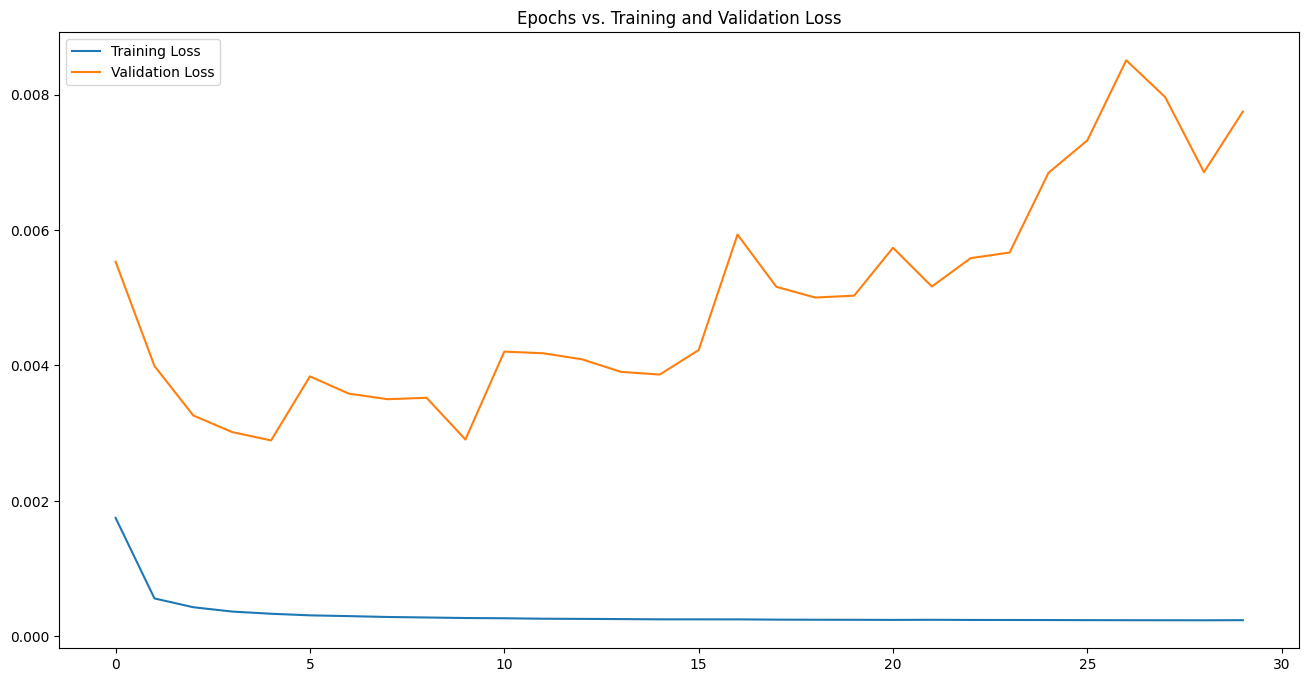

In [20]:
plot_model_loss(history)

In [21]:
forecast = model.predict(X_test)
# transforecast = y_sc.inverse_transform(forecast)

483/483 [==============================] - 14s 25ms/step


In [22]:
y_test.shape

(15447, 24)

In [23]:
y_test_inv = np.squeeze(y_test)

In [24]:
calculate_evaluation_metrics(y_test_inv[:,0], forecast[:,0])

{'RMSE': 0.053, 'MAPE': 8.253, 'NMAE': 0.084}

In [25]:
# Estrai le date e i dati corrispondenti
dates_train = dataset_input.index[:int(len(dataset_input) * train_size)]
dates_test = dataset_input.index[int(len(dataset_input) * train_size):]

In [26]:
y_train.shape

(36106, 24)

In [27]:
# Estrai le date e i dati corrispondenti con un intervallo di 6
dates_train = dataset_input.index[:int(len(dataset_input) * train_size):6]
dates_test = dataset_input.index[int(len(dataset_input) * train_size)::6]


#### Error on rows instead of columns 

In [28]:
errors = calculate_rmse_errors(y_test_inv, forecast)

In [29]:
# Ottieni il timestamp per le righe di test
test_timestamps = dataset_input.iloc[-y_test_inv.shape[0]:].index

# Converti l'indice in oggetti datetime
test_timestamps = pd.to_datetime(test_timestamps)

Errore relativo a 644 giorni, a partire da mezzanotte


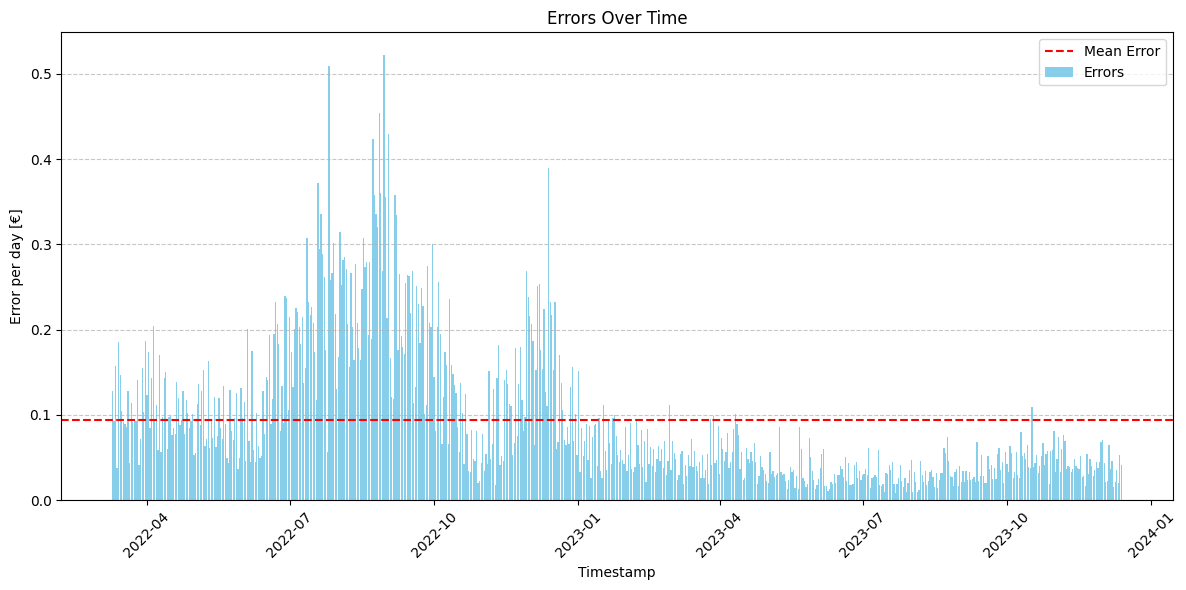

Media degli errori relativi alla mezzanotte: 0.09362603005795925


In [30]:
midnight_errors, midnight_timestamps = filter_errors_at_midnight(errors, test_timestamps)

mean_midnight_error = np.mean(midnight_errors)

visualize_errors_with_timestamps(midnight_errors, midnight_timestamps, mean_midnight_error)


print("Media degli errori relativi alla mezzanotte:", mean_midnight_error)

#### Errors on columns

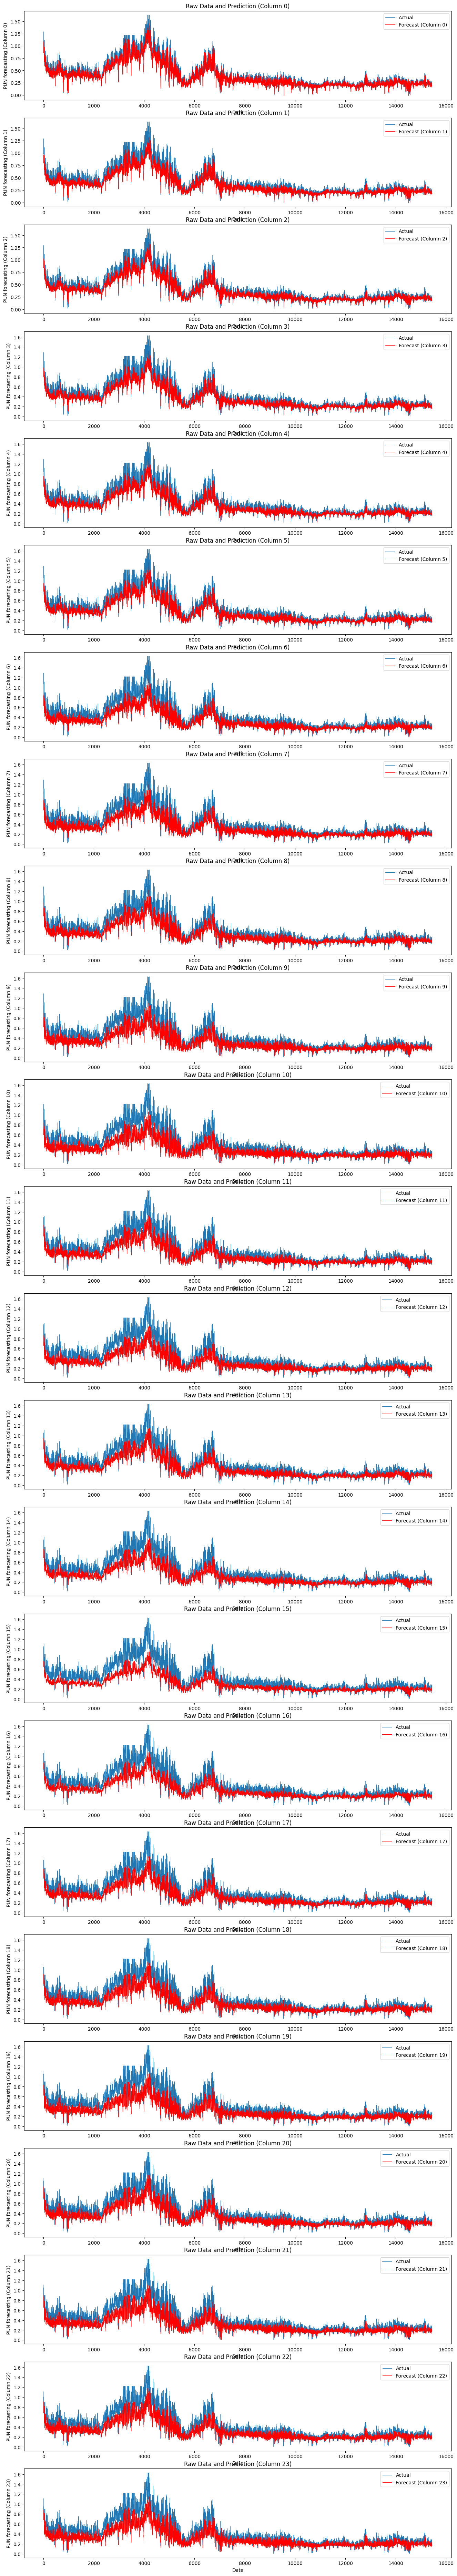

In [31]:
uni_table = evaluate_and_plot_timeseries(y_test_inv, forecast, show_plot=True)

Min NMAE: 0.084 for Column: 0.0
Min RMSE: 0.053 for Column: 0.0
Min MAPE: 8.253 for Column: 0.0
Mean NMAE: 0.22054166666666666
Mean RMSE: 0.13045833333333334
Mean MAPE: 21.24145833333333


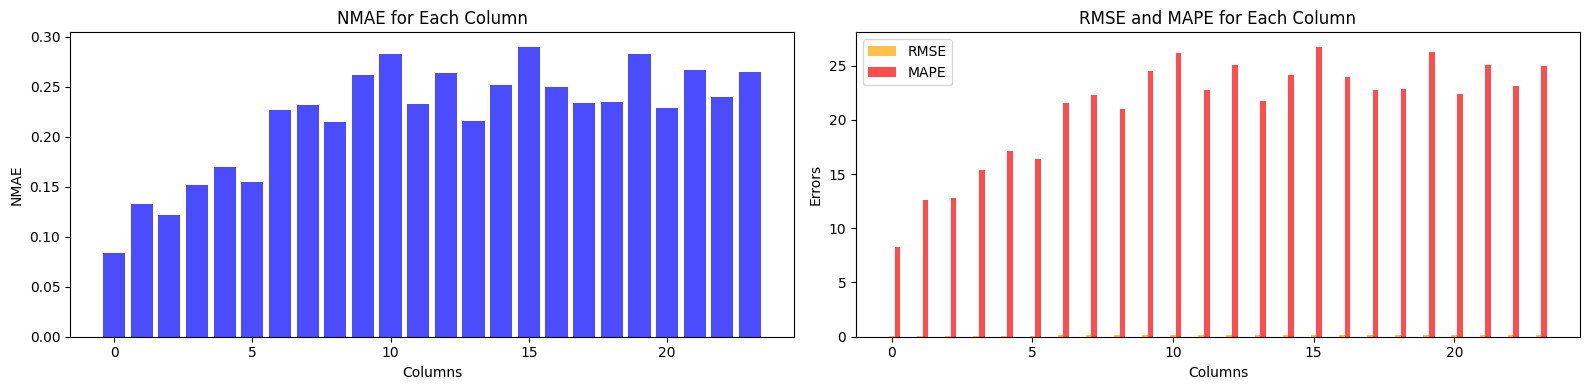

In [32]:
plot_error_metrics_barchart(uni_table)

### Simply Encoder - Decoder

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.


In [ ]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()

step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=0, 
                                    end_index=train_index, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=train_index,
                                    single_step=False)


# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


X_train shape: (36106, 24, 1)
y_train shape: (36106, 24)
X_test shape: (15447, 24, 1)
y_test shape: (15447, 24)


In [ ]:
# E1D1
n_features = X_train.shape[2]

encoder_inputs = tf.keras.layers.Input(shape=(past_history, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_l1(encoder_inputs)
encoder_states1 = [state_h1, state_c1]

decoder_inputs = tf.keras.layers.RepeatVector(target_size)(encoder_outputs1)

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(target_size))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

In [ ]:
# E2D2
encoder_inputs = tf.keras.layers.Input(shape=(past_history, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_l1(encoder_inputs)
encoder_states1 = [state_h1, state_c1]

encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_l2(encoder_outputs1)
encoder_states2 = [state_h2, state_c2]

decoder_inputs = tf.keras.layers.RepeatVector(target_size)(encoder_outputs2)

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1, initial_state=encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(target_size))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs, decoder_outputs2)

In [ ]:
# Modifica per aggiungere una dimensione per la lunghezza della sequenza temporale
y_train_ed = np.expand_dims(y_train, axis=-1)

In [ ]:

model_e1d1.compile(optimizer='adam', loss='mean_squared_error')

history_e1d1 = model_e1d1.fit(X_train, y_train_ed, epochs=25,
                            validation_split=0.2, batch_size=32,
                            verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0002, restore_best_weights=True)])

model_e2d2.compile(optimizer='adam', loss='mean_squared_error')

history_e2d2 = model_e2d2.fit(X_train, y_train_ed, epochs=50,
                            validation_split=0.2, batch_size=32,
                            verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0002, restore_best_weights=True)])


Epoch 1/25
903/903 [==============================] - 18s 13ms/step - loss: 5.3095e-04 - val_loss: 0.0149
Epoch 2/25
903/903 [==============================] - 11s 12ms/step - loss: 4.1991e-04 - val_loss: 0.0134
Epoch 3/25
903/903 [==============================] - 11s 12ms/step - loss: 3.7023e-04 - val_loss: 0.0112
Epoch 4/25
903/903 [==============================] - 11s 12ms/step - loss: 3.1505e-04 - val_loss: 0.0127
Epoch 5/25
903/903 [==============================] - 10s 11ms/step - loss: 2.5945e-04 - val_loss: 0.0115
Epoch 6/25
903/903 [==============================] - 11s 12ms/step - loss: 2.4751e-04 - val_loss: 0.0104
Epoch 7/25
903/903 [==============================] - 10s 11ms/step - loss: 2.4020e-04 - val_loss: 0.0117
Epoch 8/25
903/903 [==============================] - 11s 12ms/step - loss: 2.3385e-04 - val_loss: 0.0179
Epoch 9/25
903/903 [==============================] - 11s 12ms/step - loss: 2.3153e-04 - val_loss: 0.0222
Epoch 10/25
903/903 [=========================

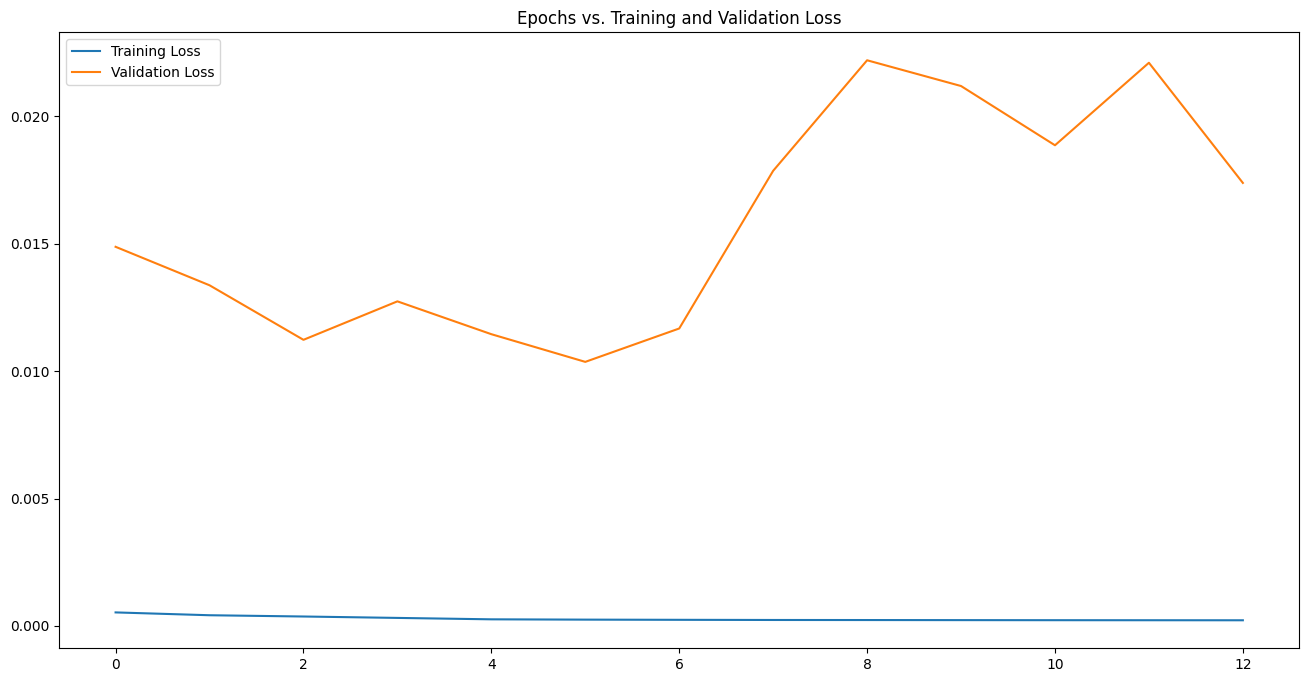

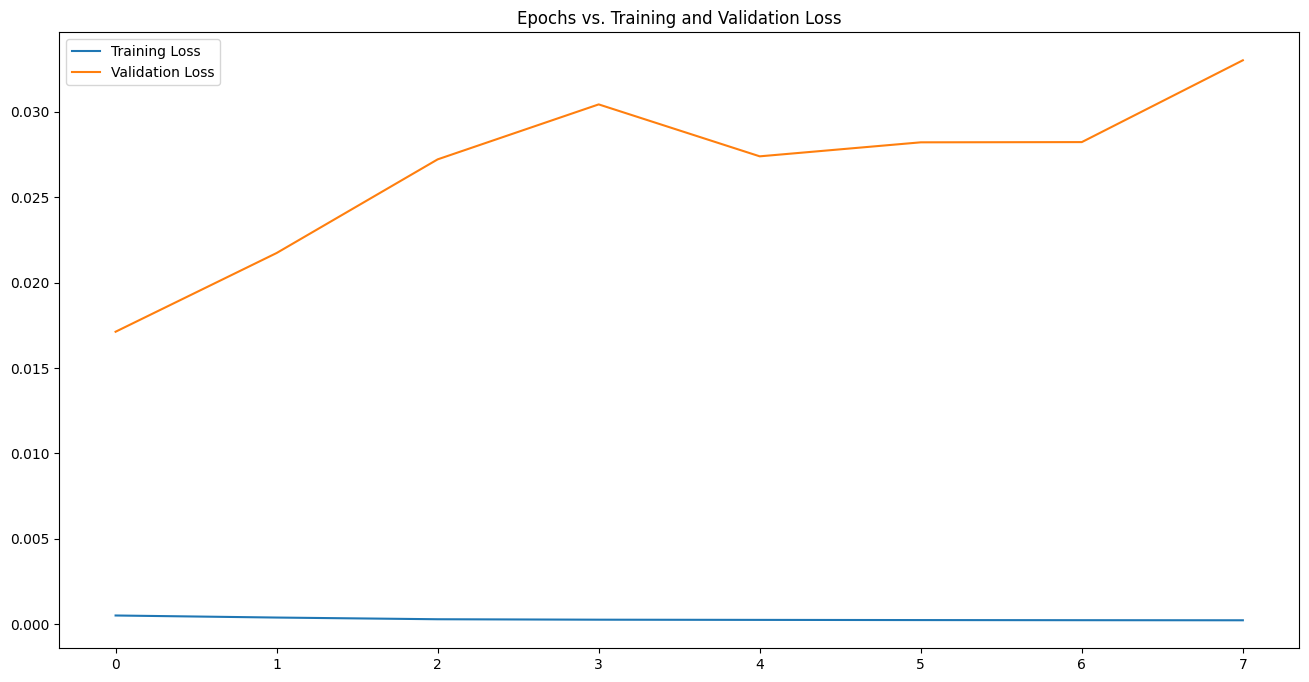

In [ ]:
plot_model_loss(history_e1d1)
plot_model_loss(history_e2d2)

In [ ]:
forecast_ed1 = model_e1d1.predict(X_test)
forecast_ed2 = model_e2d2.predict(X_test)

483/483 [==============================] - 5s 7ms/step


In [ ]:
forecast_ed1[:,:,0]=y_sc.inverse_transform(forecast_ed1[:,:,0])
forecast_ed2[:,:,0]=y_sc.inverse_transform(forecast_ed2[:,:,0])

# life hack: ctrl + d per selezionare tutte le occorrenze di un determinato carattere

Min NMAE: 0.235 for Column: 8.0
Min RMSE: 88.367 for Column: 0.0
Min MAPE: 19.437 for Column: 0.0
Mean NMAE: 0.2800416666666667
Mean RMSE: 99.263125
Mean MAPE: 24.935125


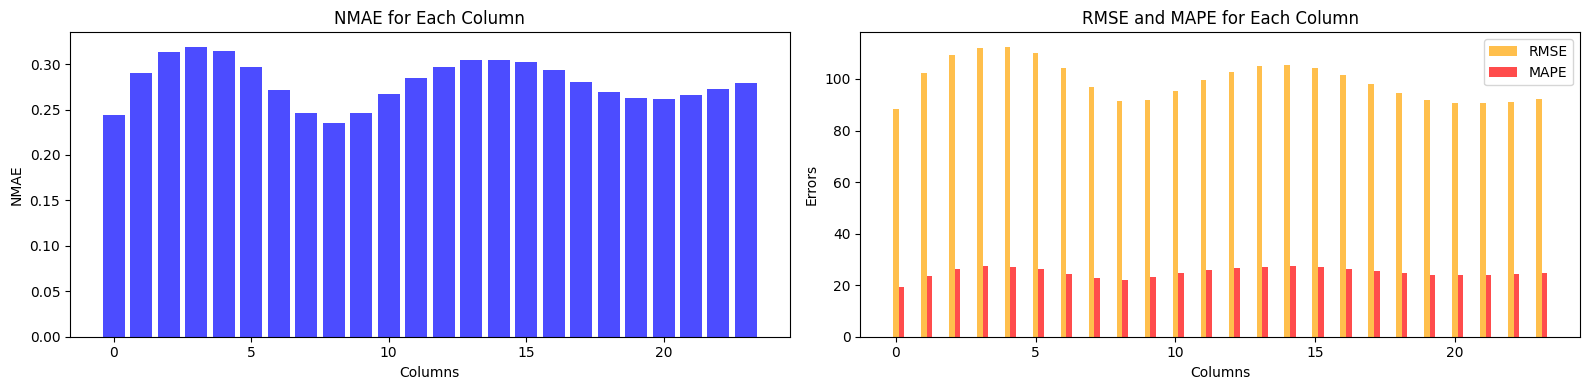

In [ ]:
lstm2_table = evaluate_and_plot_timeseries(y_test_inv, forecast_ed1[:,:,0], show_plot=False)
plot_error_metrics_barchart(lstm2_table)